In [1]:
%load_ext autoreload 
%autoreload 2 

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf

from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
model = tf.keras.models.load_model('/projects/p31961/ENIGMA/results/optimized_models/BaseClassifier_optimized')
metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc-roc')]
  
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

2023-09-14 14:13:55.780371: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38222 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:06:00.0, compute capability: 8.0
2023-09-14 14:13:55.782081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38222 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:2f:00.0, compute capability: 8.0


In [4]:
model.summary()

Model: "base_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  multiple                 31        
 n)                                                              
                                                                 
 Dense_0 (Dense)             multiple                  320       
                                                                 
 Dense_1 (Dense)             multiple                  420       
                                                                 
 Dense_2 (Dense)             multiple                  420       
                                                                 
 Dropout (Dropout)           multiple                  0         
                                                                 
 Output (Dense)              multiple                  21        
                                                   

In [118]:
DATA_PATH = '/projects/p31961/gaby_data/aggregated_data/raw_data/datasets/raw_data_raw_data.parquet.gzip'
SUBJECT_IDS_PATH = "/projects/p31961/ENIGMA/results/optimized_models/subjects.json"
cols_to_drop = ["mouse_id", "event", "sex", "day", "trial_count", "trial"]
processor = (ClassifierPipe(DATA_PATH)
            .read_raw_data()
            .calculate_max_min_signal()
            .split_data(load_subject_ids=True, 
                        subject_ids_path=SUBJECT_IDS_PATH,
                        target='action')
            .drop_features(cols_to_drop)
            .transform_data(numeric_target_dict={'avoid': 1, 'escape': 0})
            )
processor.processed_data

,action,sensor,signal_max,signal_min
0,avoid,D1,3.127942,0.191952
1,avoid,D1,0.919383,-0.615567
2,avoid,D1,-0.394839,-2.368783
3,avoid,D1,0.367330,-1.989866
4,avoid,D1,3.867368,1.411265
...,...,...,...,...
12789,escape,DA,2.978387,-1.480360
12790,escape,DA,1.694918,-2.158833
12791,escape,DA,3.849639,-1.624187
12792,escape,DA,4.559294,-1.507916


mouse_id         int64
event           object
action          object
sensor          object
sex             object
day              int64
trial_count      int64
trial            int64
signal_max     float32
signal_min     float32
dtype: object

In [110]:
cols_to_drop = ["mouse_id", "event", "sex", "day", "trial_count", "trial"]
processor.processed_data.drop(columns = cols_to_drop)

,action,sensor,signal_max,signal_min
0,avoid,D1,3.127942,0.191952
1,avoid,D1,0.919383,-0.615567
2,avoid,D1,-0.394839,-2.368783
3,avoid,D1,0.367330,-1.989866
4,avoid,D1,3.867368,1.411265
...,...,...,...,...
12789,escape,DA,2.978387,-1.480360
12790,escape,DA,1.694918,-2.158833
12791,escape,DA,3.849639,-1.624187
12792,escape,DA,4.559294,-1.507916


In [6]:
y_pred = model.predict(processor.X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred

82/82 [==============================] - 1s 993us/step


2023-09-14 14:14:08.559713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [8]:
f1_score_results = f1_score(processor.y_test, y_pred)

Text(0.5, 1.0, 'Confusion Matrix')

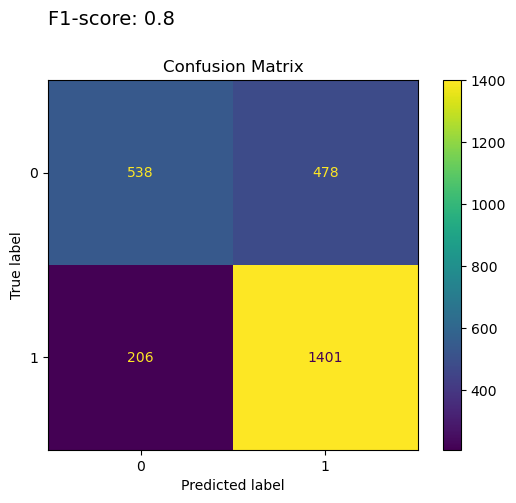

In [28]:
display = ConfusionMatrixDisplay.from_predictions(processor.y_test, y_pred)
plt.text(-.5, -.8, f"F1-score: {np.round(f1_score_results, 2)}", fontsize = 14)
plt.title('Confusion Matrix')

In [66]:
def reconstruct_df(x_data, y_data, prediction, processor):
    num_cols = processor.processor.named_transformers_["num"].get_feature_names_out().tolist()
    cat_cols = processor.processor.named_transformers_["cat"].get_feature_names_out().tolist()
    cols = num_cols + cat_cols
    print(cols)

    df = (
        pd.DataFrame(x_data, columns=cols)
        .assign(target=y_data.reset_index(drop=True),
                prediction=prediction.reshape(-1)
                ))
    return df.melt(
            id_vars = df.drop(columns = ["target", "prediction"]).columns,
            value_vars = ["target", "prediction"],
            value_name = "avoid",
            var_name = 'truth'
        )
    
    
    
    
test_df = reconstruct_df(processor = processor, 
               x_data = processor.X_test, 
               y_data = processor.y_test, 
               prediction = y_pred)
    

['mouse_id', 'day', 'trial_count', 'trial', 'signal_max', 'signal_min', 'event_avoid', 'event_cue', 'event_escape', 'event_shock', 'sensor_D1', 'sensor_D2', 'sensor_DA', 'sex_F', 'sex_M']


In [67]:
test_df

,mouse_id,day,trial_count,trial,signal_max,signal_min,event_avoid,event_cue,event_escape,event_shock,sensor_D1,sensor_D2,sensor_DA,sex_F,sex_M,truth,avoid
0,-0.257684,-0.887416,-0.913654,-0.384773,-0.035918,-0.965276,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,target,1
1,-0.257684,-0.402555,-0.497900,-1.012485,-0.309250,-0.087967,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,target,1
2,-0.257684,-0.402555,-0.463253,-0.761400,-1.062241,-0.123046,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,target,1
3,-0.257684,-0.402555,-0.393961,-0.259231,0.416706,0.756567,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,target,1
4,-0.257684,-0.402555,-0.359315,-0.008146,-0.062961,-0.681449,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,target,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5241,1.598074,-0.887416,-1.052239,-1.389112,0.436967,-0.632748,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,prediction,0
5242,1.598074,-0.887416,-1.034916,-1.263569,-0.091881,-1.109231,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,prediction,0
5243,1.598074,-0.402555,-0.549869,-1.389112,-0.135572,-0.591154,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,prediction,1
5244,1.598074,0.567166,0.437549,-1.389112,-0.679461,-1.690778,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,prediction,1


<Axes: xlabel='day', ylabel='avoid'>

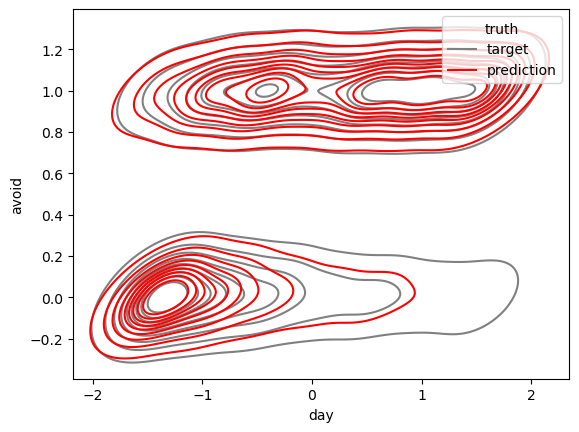

In [84]:

sns.kdeplot(data=test_df, x="day", y="avoid", hue = 'truth', palette = ['grey','red'])
# sns.kdeplot(data=test_df, x="day", y="prediction", color = 'grey')

<Axes: xlabel='avoid', ylabel='day'>

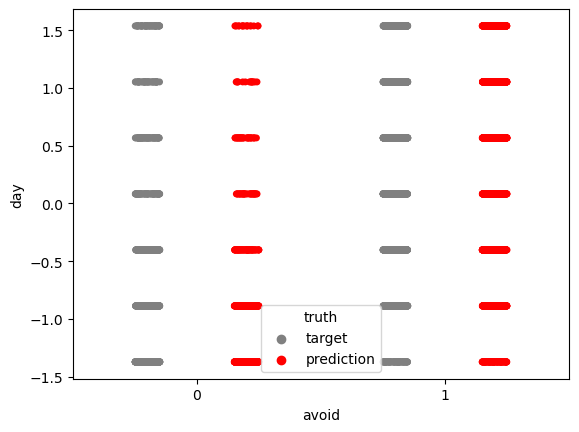

In [72]:
sns.stripplot(data=test_df, x="avoid",
              y="day",
              hue = 'truth', 
              palette = ['grey','red'],
              dodge = True,
              jitter = True
              )

<Axes: xlabel='avoid', ylabel='trial_count'>

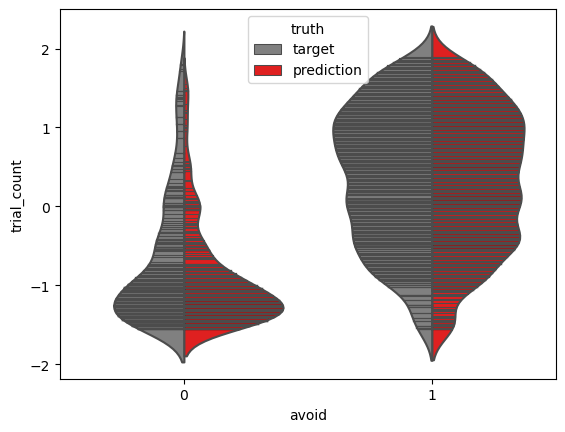

In [85]:
sns.violinplot(data=test_df,
               x="avoid",
               y="trial_count",
               hue = 'truth', 
               inner = "stick",
               split = True,
               palette = ['grey','red'])

In [86]:
processor.raw_data

,mouse_id,day,event,sensor,time,trial,signal,action,latency,sex,learning_phase,trial_count
0,12,5,cue,D2,-25.000000,0,-0.155359,escape,0.00,F,0,115
1,12,5,cue,D2,-24.901531,0,-0.420553,escape,0.00,F,0,115
2,12,5,cue,D2,-24.803064,0,-1.592294,escape,0.00,F,0,115
3,12,5,cue,D2,-24.704596,0,-1.268734,escape,0.00,F,0,115
4,12,5,cue,D2,-24.606127,0,-0.210176,escape,0.00,F,0,115
...,...,...,...,...,...,...,...,...,...,...,...,...
5860105,1,4,escape,D1,19.606127,1,0.299603,avoid,7.54,F,0,87
5860106,1,4,escape,D1,19.704596,1,-0.249408,avoid,7.54,F,0,87
5860107,1,4,escape,D1,19.803064,1,-0.486369,avoid,7.54,F,0,87
5860108,1,4,escape,D1,19.901531,1,-0.146374,avoid,7.54,F,0,87
